In [8]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
# set random seed
seed(10)

In [3]:
# load, average and merge sensor samples
data_dir = 'sample_data/bearing_data'
values = []
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        with open(os.path.join(root, filename), "r") as f:
            single_dat = f.read()
            lines = single_dat.split('\n')
            for i, line in enumerate(lines):
              try:
                line_items = [float(elem) for elem in line.split('\t')]
                values.append(line_items)
              except ValueError:
                pass

merged_data = pd.DataFrame(values, columns=["Bearing 1", "Bearing 2", "Bearing 3", "Bearing 4"])

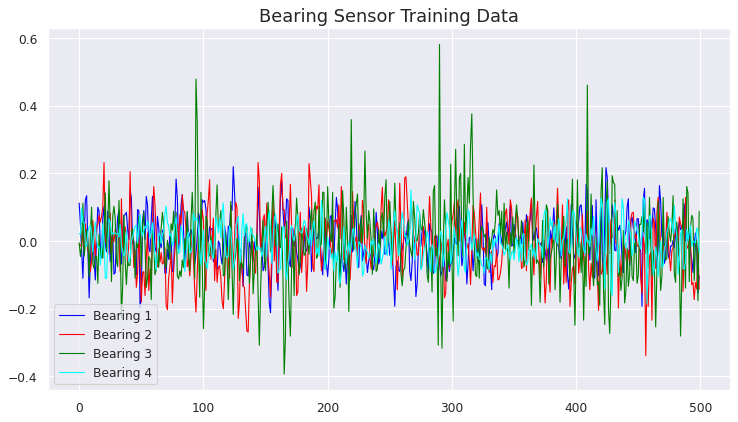

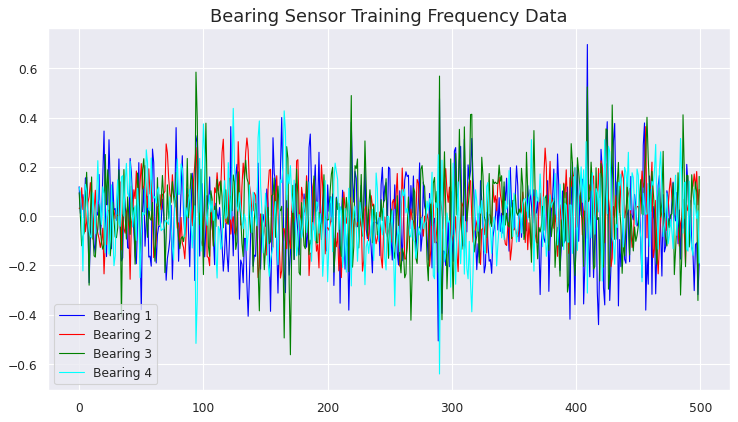

In [5]:
train = merged_data[:500]
test = merged_data[500:601]

fig, ax = plt.subplots(figsize=(11, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='cyan', linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(11, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='cyan', linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [6]:
mean = train_fft.mean()
std = train_fft.std()
X_train = (train_fft - mean) / std
X_test = (test_fft - mean) / std

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (500, 1, 4)
Test data shape: (101, 1, 4)


In [9]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)             6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              132   

In [11]:
# fit the model to the data
nb_epochs = 50
batch_size = 50
history = model.fit(X_train, 
        X_train, 
        epochs=nb_epochs, 
        batch_size=batch_size,
        validation_split=0.05).history

Epoch 1/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0250 - val_loss: 0.0272
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0260 - val_loss: 0.0248
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.0298
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0240 - val_loss: 0.0251
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0220 - val_loss: 0.0236
Epoch 6/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0205 - val_loss: 0.0227
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.0226
Epoch 8/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0191
Epoch 9/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0181
Epoch 10/50
10/10 [==============================] - 0s 9ms/step - loss: 0.0163 - val_loss: 0.0209
Epoch 11/50
10/10 

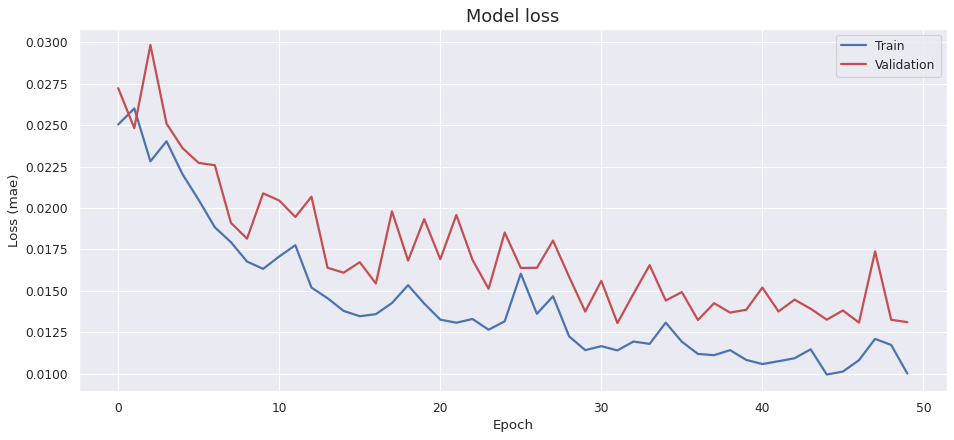

In [12]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [13]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


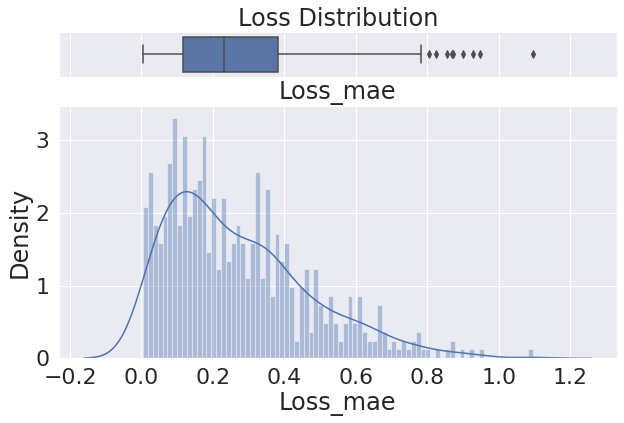

In [18]:
def histogram_boxplot(data, xlabel=None, title=None, font_scale=2, figsize=(10,6), bins=None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """

    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins, kde=True) if bins else sns.distplot(data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

histogram_boxplot(scored['Loss_mae'],  title='Loss Distribution', bins=80)

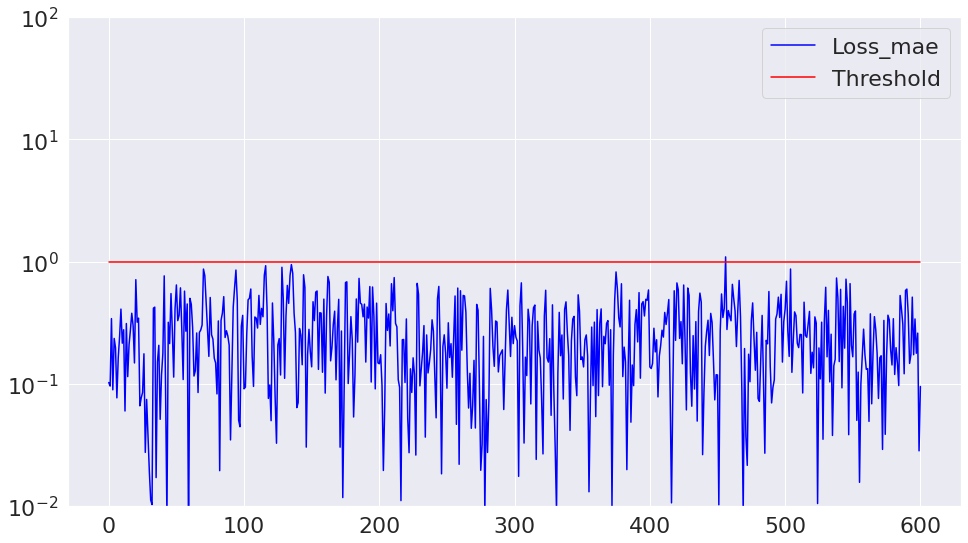

In [16]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 1.0
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 1.0
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.show()